https://setosa.io/ev/image-kernels/

In [ ]:
!pip install opencv-python numba
# !apt update && apt install libgl1-mesa-glx -y

In [56]:
import cv2
import requests
import matplotlib.pyplot as plt
import numpy as np

r = requests.get('https://roadmap2050.report/static/files/photo-building.jpg', allow_redirects=True)
open('building.jpg', 'wb').write(r.content)

test_image = cv2.imread('building.jpg')

In [57]:
from numba import cuda

@cuda.jit
def cv_histogram(image, grayscale_image):
    y,x = cuda.grid(2)
    
    if x < image.shape[0] and y < image.shape[1]:
        grayscale_image[x,y] = 0.2126*image[x,y,0] + 0.7152*image[x,y,1] + 0.0722*image[x,y,2]

In [58]:
threadsperblock = 32
xblocks = (test_image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (test_image.shape[0] + (threadsperblock - 1)) // threadsperblock

print("Xblocks: ", xblocks)
print("Yblocks: ", yblocks)

Xblocks:  18
Yblocks:  18


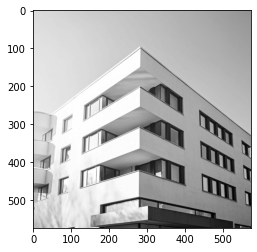

In [59]:
gray_img = np.zeros(shape=(test_image.shape[0], test_image.shape[1]), dtype=np.uint8)
# test_image = test_image.astype(np.uint32)

blocks_per_grid = (xblocks, yblocks)

cv_histogram[blocks_per_grid, (threadsperblock, threadsperblock)](test_image, gray_img)

plt.figure()
plt.imshow(gray_img, cmap="gray", vmin=0, vmax=255)

In [117]:

@cuda.jit
def convolute_2d(image, kernel, kernel_size, output):
    y,x = cuda.grid(2)
    
    if x + kernel_size < image.shape[0] and y + kernel_size < image.shape[1]:
        sum = 0
        for i in range(kernel_size):
            for j in range(kernel_size):
                sum += kernel[i,j] * image[x + i, y + j]
        output[x,y] = sum

@cuda.jit
def pool_max(image, kernel_size, output):
    y,x = cuda.grid(2)
    
    if x + kernel_size < image.shape[0] and y + kernel_size < image.shape[1]:
        for i in range(kernel_size):
            for j in range(kernel_size):
              if image[x + i, y + j] > output[x,y]: 
                output[x,y] = image[x + i, y + j]

def convolution_2d_cpu(image, kernel, kernel_size, output):
  for x in range(image.shape[0]):
    for y in range(image.shape[1]):
      if x + kernel_size < image.shape[0] and y + kernel_size < image.shape[1]:
        sum = 0
        for i in range(kernel_size):
            for j in range(kernel_size):
                sum += kernel[i,j] * image[x + i, y + j]
        output[x,y] = sum


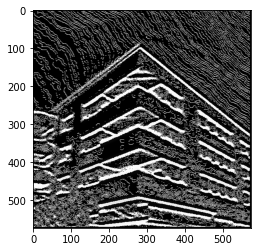

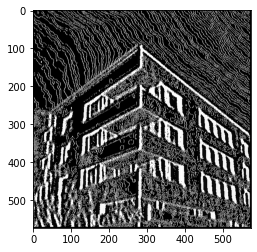

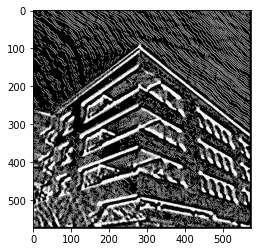

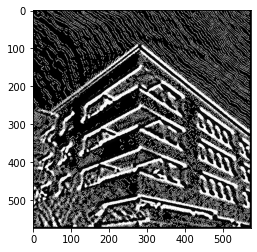

In [112]:
## Trick from canny operator, blur the image first to reduce noise
blur = cv2.GaussianBlur(gray_img, (17,17), 0)

output = np.zeros(shape=(gray_img.shape[0], gray_img.shape[1]), dtype=np.uint8)
# test_image = test_image.astype(np.uint32)
kernel_ud = np.array([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]]) # Edge detect up/down
kernel_lr = np.array([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]]) # Edge detect left/right
kernel_dtb = np.array([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]]) # Edge detect diag top/buttom
kernel_dbt = np.array([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]]) # Edge detect diag buttom/top

blocks_per_grid = (xblocks, yblocks)

convolute_2d[blocks_per_grid, (threadsperblock, threadsperblock)](blur, kernel_ud, kernel_ud.shape[0], output)

plt.figure()
plt.imshow(output, cmap='gray')

convolute_2d[blocks_per_grid, (threadsperblock, threadsperblock)](blur, kernel_lr, kernel_lr.shape[0], output)

plt.figure()
plt.imshow(output, cmap='gray')

convolute_2d[blocks_per_grid, (threadsperblock, threadsperblock)](blur, kernel_dtb, kernel_dtb.shape[0], output)

plt.figure()
plt.imshow(output, cmap='gray')

convolute_2d[blocks_per_grid, (threadsperblock, threadsperblock)](blur, kernel_dbt, kernel_dbt.shape[0], output)

plt.figure()
plt.imshow(output, cmap='gray')

1 loop, best of 5: 2.51 s per loop
1000 loops, best of 5: 1.92 ms per loop
100 loops, best of 5: 2.87 ms per loop


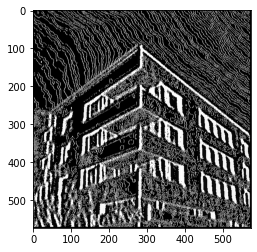

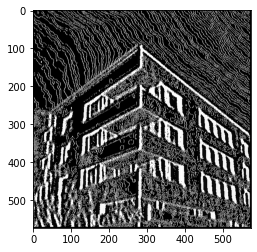

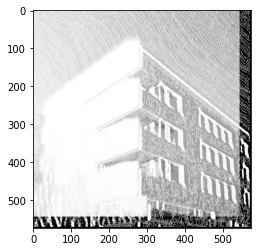

In [120]:
%timeit convolution_2d_cpu(blur, kernel_lr, kernel_lr.shape[0], output)
plt.figure()
plt.imshow(output, cmap='gray')
%timeit convolute_2d[blocks_per_grid, (threadsperblock, threadsperblock)](blur, kernel_lr, kernel_lr.shape[0], output)
plt.figure()
plt.imshow(output, cmap='gray')
%timeit pool_max[blocks_per_grid, (threadsperblock, threadsperblock)](blur, 30, output)
plt.figure()
plt.imshow(output, cmap='gray')